In [ ]:
import csv
import pandas as pd
import numpy as np
import os
import torch
import pickle
import datetime
from torch.utils.data import TensorDataset

In [ ]:
! ls data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
with open("data/lvl2_train.pkl", "rb") as f:
    data = pickle.load(f).sort_values(['subject_id', 'hadm_id', 'icustay_id'])

with open("data/Ys_train.pkl", "rb") as f:
    labels = pickle.load(f).sort_values(['subject_id', 'hadm_id', 'icustay_id'])
    
data = data.reset_index(drop=True).droplevel(level="LEVEL2", axis=1)
features = data["mean"].to_numpy()
masks = data["mask"].to_numpy()

features = np.split(features, [48 * i for i in range(1, len(features) // 48)])
masks = np.split(masks, [48 * i for i in range(1, len(masks) // 48)])

features = torch.tensor(features, dtype=torch.float).to(device)
masks = torch.tensor(masks, dtype=torch.float).to(device)
labels = torch.squeeze(torch.tensor(labels.to_numpy(), dtype=torch.float).to(device))

print(f"Shape of features: {features.size()}")
print(f"Shape of masks: {masks.size()}")
print(f"Shape of labels: {labels.size()}")
assert len(features) == len(labels)
assert features.size() == masks.size()

d = TensorDataset(features, masks, labels)

In [ ]:
print(f"Dataset size: {len(features)} ICU stays with 48-hour timeseries for {features.size()[2]} measurements each")

In [ ]:
from torch.utils.data import DataLoader, random_split
 
splits = [int(round(len(d) * 8 / 10)), int(round(len(d) / 10)), int(round(len(d) / 10))]
train_data, test_data, validation_data = random_split(d, splits, torch.Generator())

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
validation_dataloader = DataLoader(validation_data, batch_size=len(validation_data), shuffle=False)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score


constant_classifier = DummyClassifier(strategy="constant", constant=1)
uniform_classifier = DummyClassifier(strategy="uniform")

inputs, labels = None, None
for inp, mask, lab in validation_dataloader:
    inputs, labels = inp, lab
    labels = labels.clone().cpu().detach()

constant_classifier.fit([0] * len(labels), labels)
uniform_classifier.fit([0] * len(labels), labels)
y_constant = constant_classifier.predict([0] * len(labels))
y_uniform = uniform_classifier.predict([0] * len(labels))

print(f"Baseline F1 score constant 1: {f1_score(labels, y_constant)}")
print(f"Baseline F1 score uniform: {f1_score(labels, y_uniform)}")

In [ ]:
GAMMA = 0.5
N = 16
LAMBDA = 1.3
LR = 0.001
OMEGA = 0.001

In [ ]:
import torch.nn as nn
import torch.nn.utils.rnn as rnn

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.rnn = nn.GRU(input_size=104, hidden_size=32, num_layers=1, bidirectional=False, batch_first=True)
        self.fc1 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x, mask):
        try:
            x = x * mask
        except:
            print(x, mask)
        _, h_n = self.rnn(x)
        fc1_out = self.fc1(torch.squeeze(h_n))
        # Multiply prediction value before sigmoid activation by gamma.
        # This is part of the micro framework.
        r = torch.mul(fc1_out, GAMMA)
        res = torch.sigmoid(r)
        return torch.squeeze(res)

tinymodel = TinyModel()
tinymodel.to(device)

print('The model:')
print(tinymodel)

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(tinymodel.parameters(), LR)

def loss_func(y_hat, y, model):
    # Add a dimension when there is only one item in the batch.     
    if len(y_hat.size()) == 0:
        y_hat = torch.unsqueeze(y_hat, dim=0)

    l1 = OMEGA * sum(p.abs().sum() for p in model.parameters())
    cr = (1 / GAMMA) * criterion(y_hat, y)
    
    # Calculate the loss. The regularization is just an l1 regularization with a coefficient.
    # The criterion is the binary cross-entropy multiplied by 1 / GAMMA, a part of the micro framework.
    return l1 + cr

    # The paper also says to subtract batch_size / N, but this value is different for different batches depending
    # on the number of easy tasks in the batch, making it hard to compare loss across batches. Crucially, this 
    # is confusing when you look at the loss on training data (non-full batches) vs loss on testing data (full-size batches).
    # This makes me think that actually the paper meant that you first pick easy tasks across the entire testing set,
    # and then split it into batches rather than split into batches first and pick easy tasks after.
    # batch_size = y_hat.size()[0]    
    # neg = batch_size / N
    # return l1 + cr - neg

In [ ]:
def pick_easy_tasks(model, x, mask, y, N):
    criterion = nn.BCELoss(reduction='none')
    model.train(False)
    y_hat = model(x, mask)

    # Pick tasks in the batch for which the loss is less than 1 / N.
    loss = torch.add((1 / GAMMA) * criterion(y_hat, y), -1 / N)
    easy_indices = list((loss < 0).nonzero())

    easy_timeseries = torch.empty((len(easy_indices), x.size()[1], x.size()[2]))
    easy_masks = torch.empty((len(easy_indices), x.size()[1], x.size()[2]))
    easy_labels = torch.empty((len(easy_indices),))

    for i, index in enumerate(easy_indices):
        index = index.item()
        easy_timeseries[i] = x[index]
        easy_masks[i] = mask[index]
        easy_labels[i] = y[index]

    model.train(True)
    return torch.Tensor(easy_timeseries).to(device), torch.Tensor(easy_masks).to(device), torch.Tensor(easy_labels).to(device)


In [ ]:
# TODO: implement early stopping
for epoch in range(40):
    running_loss = 0.0
    number_examples_used = 0
    num_examples = 0
    for i, (features, masks, labels) in enumerate(train_dataloader):
        num_examples = num_examples + len(features)
        tinymodel.train(True)
        optimizer.zero_grad()
        
        # Pick easy sequences with the current N. If no sequences are easy, skip the batch.
        easy_timeseries, easy_masks, easy_labels = pick_easy_tasks(tinymodel, features, masks, labels, N)
        if len(easy_timeseries) == 0:
            continue
        else:
            number_examples_used = number_examples_used + len(easy_timeseries)

        # Train on easy sequences.
        easy_output = tinymodel(easy_timeseries, easy_masks)
        loss = loss_func(easy_output, easy_labels, tinymodel)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 50 == 0:
            print(f'Epoch: [{epoch + 1}, training batch {i + 1:5d}] running training loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    
    running_test_loss = 0.0
    tinymodel.train(False)
    print(f"In epoch {epoch + 1}, number of examples trained on is {number_examples_used} out of {num_examples}")
    for i, (test_inputs, test_masks, test_labels) in enumerate(test_dataloader):
        test_outputs = tinymodel(test_inputs, test_masks)
        test_loss = loss_func(test_outputs, test_labels, tinymodel)
        running_test_loss += test_loss
    
    print(f"Test loss: {running_test_loss / len(test_dataloader)}")
    # Decrease N by a factor of lambda and as such increase 1 / N, so increase the loss threshold that defines
    # what tasks are considrered easy.
    N = N / LAMBDA

print('Finished Training')

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

tinymodel.train(False)
out = None
lab = None
for inputs, masks, labels in validation_dataloader:
    outputs = tinymodel(inputs, masks)
    out = outputs
    outputs = outputs > 0.5
    lab = labels
    labels = labels.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    print(f"F1 score: {f1_score(labels, outputs)}")
    print(f"ROC AUC: {roc_auc_score(labels, outputs)}")

137.0
1559


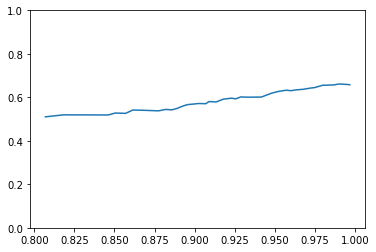

In [78]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Fill with real values
preds = out.cpu().detach().numpy()
true_labels = lab.cpu().detach().numpy()
print(sum(true_labels))
print(len(true_labels))

confidence = 0.5 + abs(preds - 0.5)

def mean(x):
    return sum(x) / len(x)

coverages = []
calculated_metrics = []

for confidence_treshold in np.arange(0.5, 1.00000000, 0.01):
    predicted_labels = 1.0 * (preds > 0.5)
    
    replace_mask = confidence < confidence_treshold
    predicted_labels[replace_mask] = 0

    coverage = mean(1.0 * (confidence > confidence_treshold))

    if len(true_labels[replace_mask]) == 0 or sum(predicted_labels) == 0:
        continue

    auc = metrics.roc_auc_score(true_labels[~replace_mask], predicted_labels[~replace_mask])
    
    calculated_metrics.append(auc)
    coverages.append(coverage)
    
plt.plot(coverages, calculated_metrics)
plt.ylim(0, 1) 
plt.show()

In [79]:
print(coverages)

[0.9967928159076331, 0.994868505452213, 0.9916613213598461, 0.9897370109044259, 0.9871712636305324, 0.9820397690827454, 0.9801154586273252, 0.9749839640795381, 0.9717767799871713, 0.967928159076331, 0.962796664528544, 0.9602309172546504, 0.9570237331622835, 0.9525336754329699, 0.9480436177036562, 0.9416292495189224, 0.9332905708787684, 0.9288005131494548, 0.9255933290570879, 0.9230275817831943, 0.9178960872354073, 0.9134060295060936, 0.90891597177678, 0.9069916613213599, 0.9025016035920462, 0.895445798588839, 0.8928800513149455, 0.8890314304041051, 0.8858242463117383, 0.881975625400898, 0.8774855676715844, 0.868505452212957, 0.8614496472097498, 0.8569595894804362, 0.8505452212957024, 0.8460551635663887, 0.8351507376523413, 0.8248877485567672, 0.8184733803720333, 0.8069275176395125]
